The single-cell objects are large, so please use a machine with high memory

# Load dependencies

In [17]:
#install.packages('mixtools')
#BiocManager::install('limma')

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.17), R 4.1.3 (2022-03-10)

Installing package(s) 'limma'

Old packages: 'globals', 'httr', 'leiden', 'reticulate', 'spatstat.utils',
  'xfun'



In [16]:
library(Seurat)
library(dplyr)
library(stringr)
library(scales)
library(ggplot2)
library(ggrepel)
library(tidyverse)
library(RColorBrewer)

In [4]:
`%notin%` <- Negate(`%in%`)

# Setup custom theme for plotting.
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

set.seed(1234)

In [5]:
working_directory="~/stochastic_regulation_code/accessory_files/"

# Doublet removal and dataset QC (figure 4B and S4A)

In [6]:
seurat_object_file_path <- paste(working_directory,"JL_011_seurat_obj_v061721.RDS", sep="")
experiment_name <- "JL_011"
timepoints=c("0hr","2hr","4hr","6hr","8hr","10hr")

seurat_obj <- readRDS(seurat_object_file_path)
seurat_obj=RenameAssays(object = seurat_obj, RNA = 'total')

Renaming default assay from RNA to total

Warning message:
“Cannot add objects with duplicate keys (offending key: rna_) setting key to original value 'total_'”


QC plots of the object. UMAP representations are performed using the RNA layer (i.e. total). We see a batch effect related to the time of collection, but within each time point cell cycle seems to be the main driver of structure. We will compute correlations between TFs and targets within each time point, and avoid the use of batch correction strategies to correct counts.

In [7]:
DefaultAssay(object = seurat_obj) <- 'total'
seurat_obj <- FindVariableFeatures(seurat_obj) %>% ScaleData()


Centering and scaling data matrix



In [8]:
seurat_obj <- RunPCA(object = seurat_obj)


PC_ 1 
Positive:  HMGB2, ARL6IP1, KPNA2, CCNB1, CDK1, PRC1, CKS2, KIF23, BIRC5, TPX2 
	   TOP2A, KIF2C, NEK2, CDC20, ASPM, TACC3, RACGAP1, CENPF, AURKA, CENPE 
	   MKI67, NDC80, SMC4, CCNA2, CCNB2, DEPDC1, KIF4A, PTTG1, NUF2, KIF20A 
Negative:  TRIM56, ACTG1, PPM1F, ANXA11, ARPC1B, CAVIN1, C10orf128, MCM4, PRKCB, UNG 
	   SPN, SLC43A3, MCM6, TYMS, ST6GAL1, SLC2A3, AC079466.1, PKM, MARCKSL1, CMBL 
	   CMIP, LDHA, MCRIP2, TRIM44, MSH6, MRTO4, VCL, PTPN7, TMC6, CMTM3 
PC_ 2 
Positive:  MT-RNR2, MT-ND1, MT-ND3, HEMGN, MT-RNR1, MTATP6P1, MT-ND2, RPS2P5, MT-ATP6, MKI67 
	   MT-CO1, MT-CO2, MTND2P28, AC079466.1, RPS2P46, MALAT1, LINC00958, ARHGAP11A, HBG1, STMN1 
	   CENPF, HBG2, TPX2, MRTO4, SLC25A37, MT-ND5, MT-ATP8, HSP90AA1, MTRNR2L8, HBE1 
Negative:  PFDN2, MCL1, IQGAP1, RPLP2, ANXA5, CRKL, NASP, ARRDC4, ATP6V1B2, SNRNP200 
	   LCP1, LEO1, HEXB, SLC39A7, PCF11, SAMD8, GOLGA2, CUL3, RBM33, TPM4 
	   ZBTB43, PRDM4, DDAH2, STX3, CYTH1, KRT8, EPC1, PNPLA8, CIR1, FEM1B 
PC_ 3 
Positive:  RPLP

In [9]:
seurat_obj <- RunUMAP(object = seurat_obj, dims = 1:40)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
23:36:48 UMAP embedding parameters a = 0.9922 b = 1.112

23:36:48 Read 14544 rows and found 40 numeric columns

23:36:48 Using Annoy for neighbor search, n_neighbors = 30

23:36:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:36:51 Writing NN index file to temp file /tmp/RtmpvqiSPo/filed71418d7e17

23:36:51 Searching Annoy index using 1 thread, search_k = 3000

23:36:57 Annoy recall = 100%

23:36:57 Commencing smooth kNN distance calibration using 1 thread

23:36:58 Initializing fro

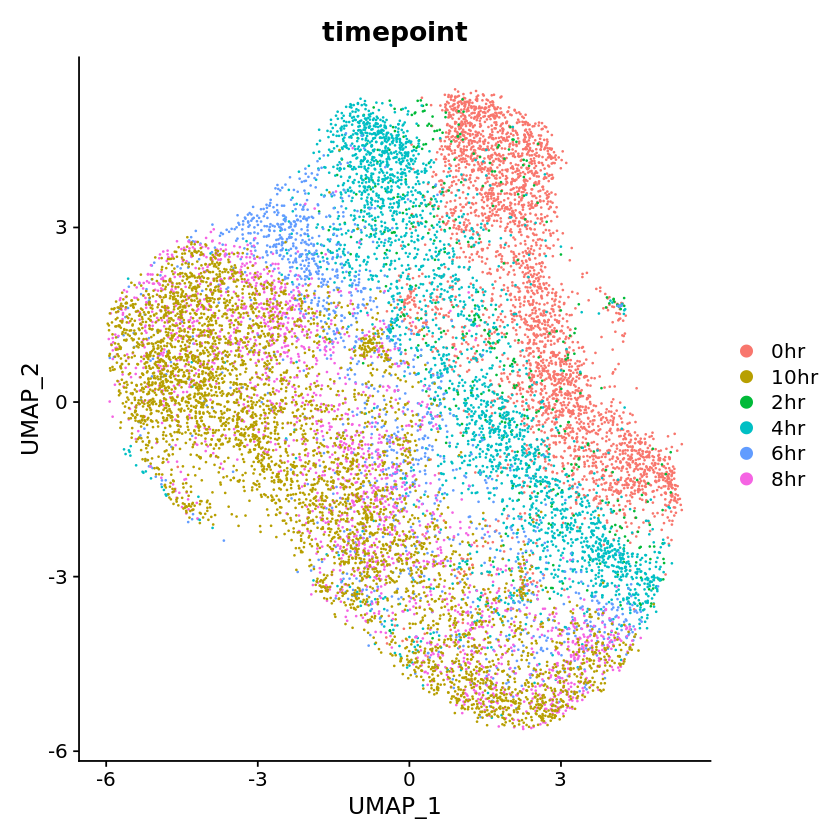

In [17]:
DimPlot(seurat_obj, group.by="timepoint")

In [13]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

seurat_obj_cc <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


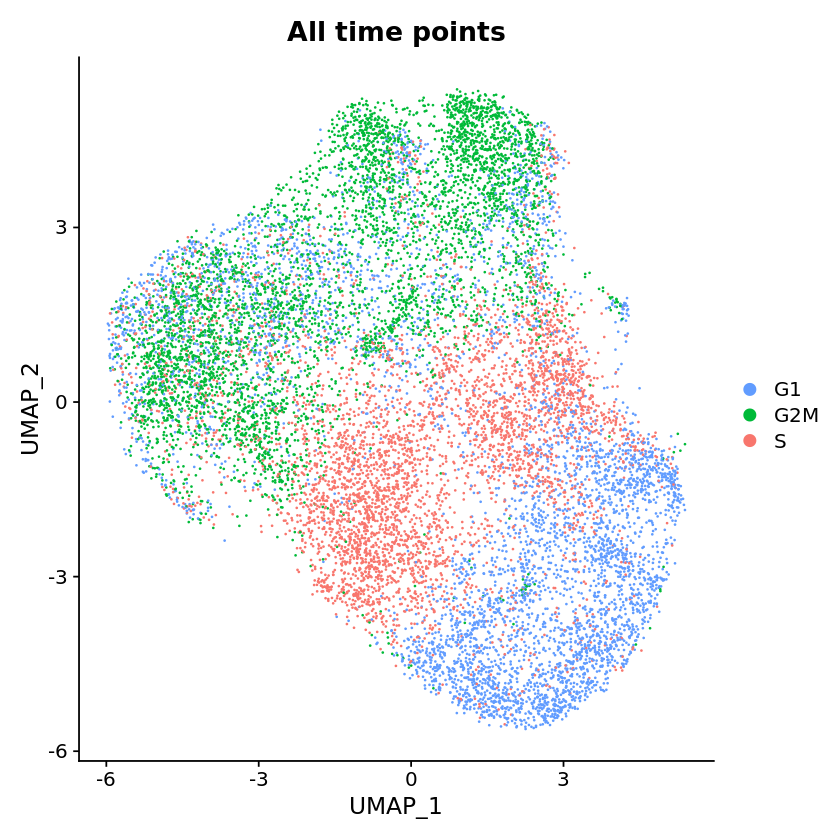

In [14]:
DimPlot(seurat_obj_cc,cols = c('G1' = '#619CFF', 'G2M' = '#00BA38', 'S' = '#F8766D'))  + ggtitle("All time points") +
  theme(plot.title = element_text(hjust = 0.5)) 

## Figure S4

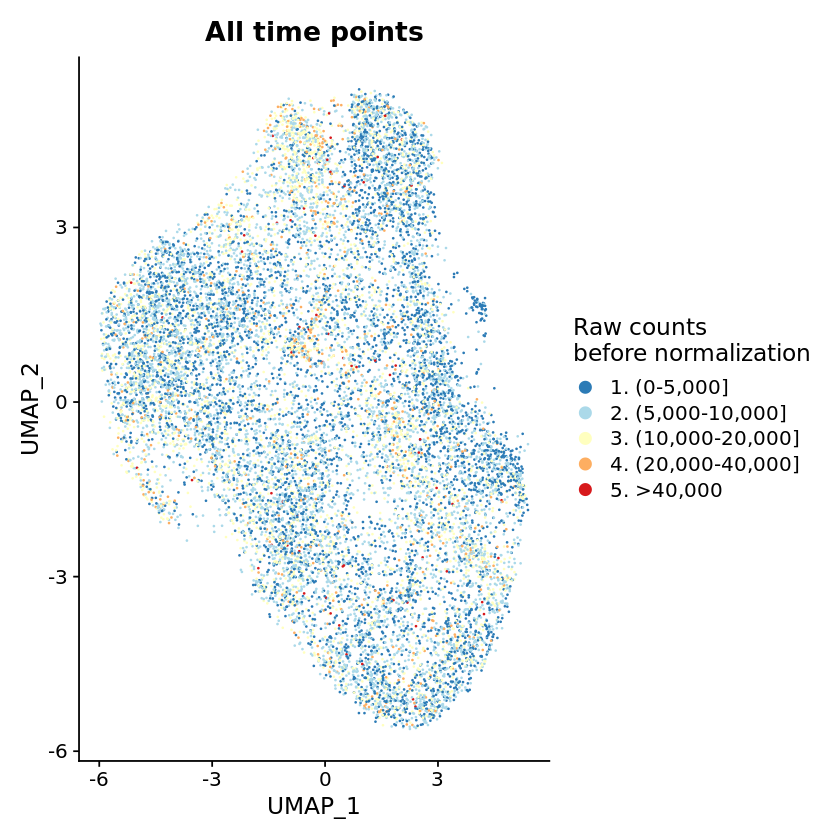

In [18]:
# Binning by raw total counts

    b <- c(0,5000,10000,20000,40000,100000)
    binned_total_counts <- .bincode(seurat_obj@meta.data$nCount_raw_total, b, TRUE)

    binned_total_counts <- dplyr::recode(binned_total_counts, `1` = "1. (0-5,000]",
              `2`= "2. (5,000-10,000]",
              `3`= "3. (10,000-20,000]",
              `4`= "4. (20,000-40,000]",
              `5`= "5. >40,000")

    seurat_obj@meta.data$binned_total_counts <- binned_total_counts
    
    #583 x 443
    DimPlot(seurat_obj, reduction = "umap", group.by = "binned_total_counts") + ggtitle("All time points") + scale_colour_manual(name = "Raw counts\nbefore normalization", limits =c("1. (0-5,000]","2. (5,000-10,000]","3. (10,000-20,000]","4. (20,000-40,000]","5. >40,000"), values =rev(brewer.pal(n = 5, name = "RdYlBu")) ,drop = FALSE)

## Figure 4B

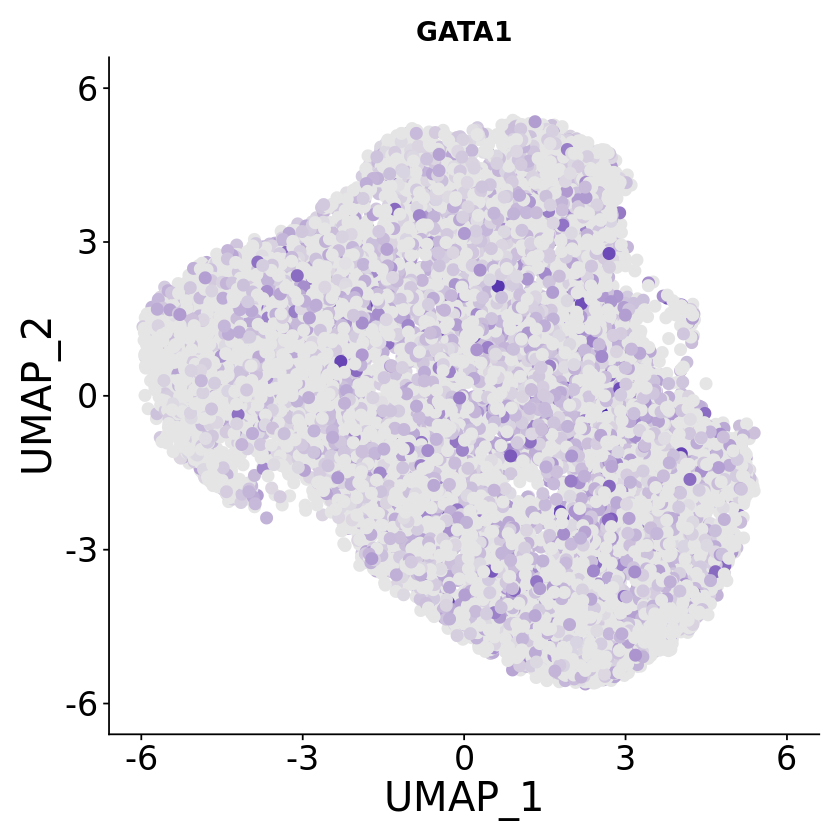

In [23]:
FeaturePlot(seurat_obj, "GATA1", cols = c("grey90", "#1300A1"),pt.size=3)+ theme(legend.position = "none") +theme(axis.text=element_text(size=20),
                                                    axis.title=element_text(size=24), legend.text=element_text(size=20))

Showing the structure due to total counts, as well as cell cycle, in each of the time points separately:

In [19]:
# Create a Seurat object for each of the timepoints
count=0
for (t in timepoints){
cells_timepoint <- colnames(seurat_obj)[grep(paste("-",count,sep=""), colnames(seurat_obj))]
assign(paste("seurat_obj_", t, sep = ""), seurat_obj[,cells_timepoint])
count=count+1
}

UMAP_562_total_counts_timepoint=list()
UMAP_562_cell_cycle_timepoint=list()
count=0
for (seurat_obj_timepoint in paste("seurat_obj_",timepoints,sep="")){
  count=count+1
  #DefaultAssay(object = get(seurat_obj_timepoint)) <- 'total'
  seurat_obj_timepoint <- get(seurat_obj_timepoint)
  seurat_obj_timepoint <- FindVariableFeatures(seurat_obj_timepoint) %>% ScaleData()
  seurat_obj_timepoint <- RunPCA(object = seurat_obj_timepoint)
  seurat_obj_timepoint <- RunUMAP(object = seurat_obj_timepoint, dims = 1:40)

  seurat_obj_timepoint <- CellCycleScoring(seurat_obj_timepoint, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
  
  UMAP_562_cell_cycle_timepoint[[count]]<-DimPlot(seurat_obj_timepoint,cols = c('G1' = '#619CFF', 'G2M' = '#00BA38', 'S' = '#F8766D')) + theme(legend.position = "none") + ggtitle(paste(timepoints[count]," chase",sep="")) +
  theme(plot.title = element_text(hjust = 0.5))
  
  # Binning by raw total counts

    b <- c(0,5000,10000,20000,40000,100000)
    binned_total_counts <- .bincode(seurat_obj_timepoint@meta.data$nCount_raw_total, b, TRUE)

    binned_total_counts <- dplyr::recode(binned_total_counts, `1` = "1. (0-5,000]",
              `2`= "2. (5,000-10,000]",
              `3`= "3. (10,000-20,000]",
              `4`= "4. (20,000-40,000]",
              `5`= "5. >40,000")

    seurat_obj_timepoint@meta.data$binned_total_counts <- binned_total_counts

  UMAP_562_total_counts_timepoint[[count]]<-DimPlot(seurat_obj_timepoint, reduction = "umap", group.by = "binned_total_counts") + ggtitle(paste(timepoints[count]," chase",sep="")) + scale_colour_manual(limits =c("1. (0-5,000]","2. (5,000-10,000]","3. (10,000-20,000]","4. (20,000-40,000]","5. >40,000"), values =rev(brewer.pal(n = 5, name = "RdYlBu")) ,drop = FALSE) + theme(legend.position = "none") 
}

Centering and scaling data matrix

PC_ 1 
Positive:  MKI67, HMGB2, CCNB1, KPNA2, TPX2, BIRC5, TOP2A, CDC20, CENPF, KIF2C 
	   CDK1, ASPM, KIF23, CENPE, CKAP2L, PRC1, ARHGAP11A, KIF20A, ARL6IP1, AURKA 
	   TACC3, PIF1, NDC80, KIF14, CCNA2, NEK2, CDCA8, CKAP2, DEPDC1, RACGAP1 
Negative:  TRIM56, MSH6, ACTG1, MCM4, PPM1F, UNG, CAVIN1, AC079466.1, C10orf128, PDE4DIP 
	   SLC2A3, MCM6, CHD4, LAPTM4B, PKM, TRIM44, NEAT1, RRBP1, VIM, MTATP6P1 
	   TPM4, TMC6, BHLHE40, DTL, CMBL, CD53, PRKCB, CDK6, VCL, DDX21 
PC_ 2 
Positive:  HBG1, HBG2, HBE1, HEMGN, SLC25A37, BLVRB, ALAS2, HBZ, HMBS, NARF 
	   HBA2, HBA1, FAXDC2, PPOX, MYL4, GYPA, TNS1, TYMS, ADD2, UBAC1 
	   TFRC, TUBA1B, AHSP, RHCE, MCM7, SLC30A10, HBBP1, OAT, SLC4A1, FECH 
Negative:  VIM, SLC38A2, ANXA1, RTN4, STX3, TPM4, SLC38A1, GFPT1, ANKRD11, AAK1 
	   SAMSN1, BOD1L1, MTHFD2, ZKSCAN1, CHD2, GOLGB1, IQGAP1, FAM129A, NR2F2, MT-ATP8 
	   SPTBN1, DDAH2, TES, KLF6, IFI16, SESN2, JMJD1C, STXBP5, MT-CYB, SLC2A3 
PC_ 3 
Positive:  LPAR4, FEM

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


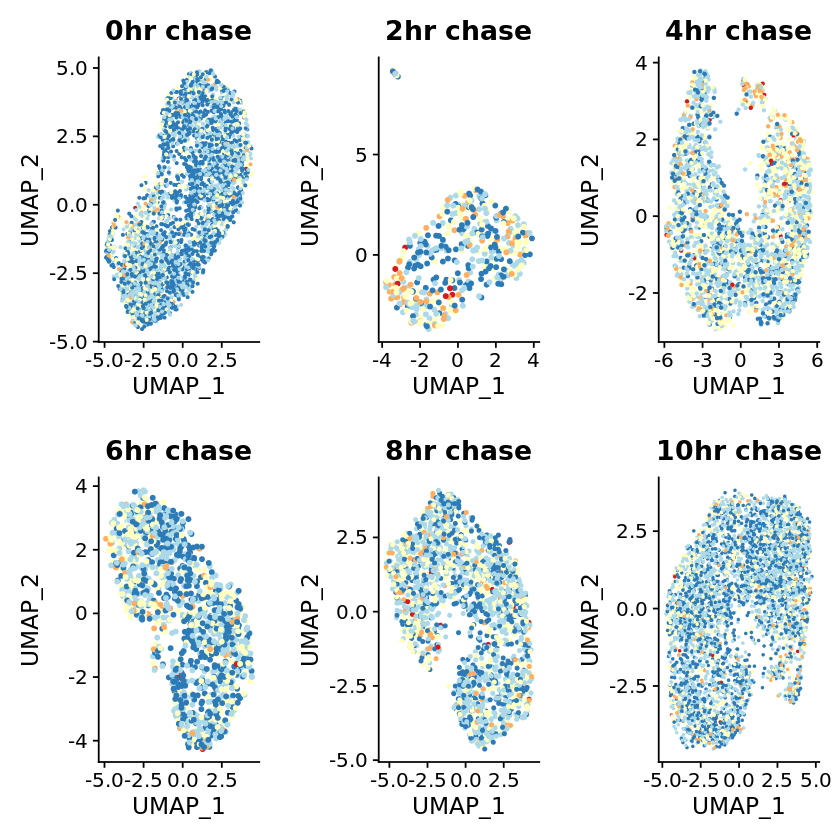

In [20]:
CombinePlots(UMAP_562_total_counts_timepoint, ncol = NULL, legend = "none") 

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


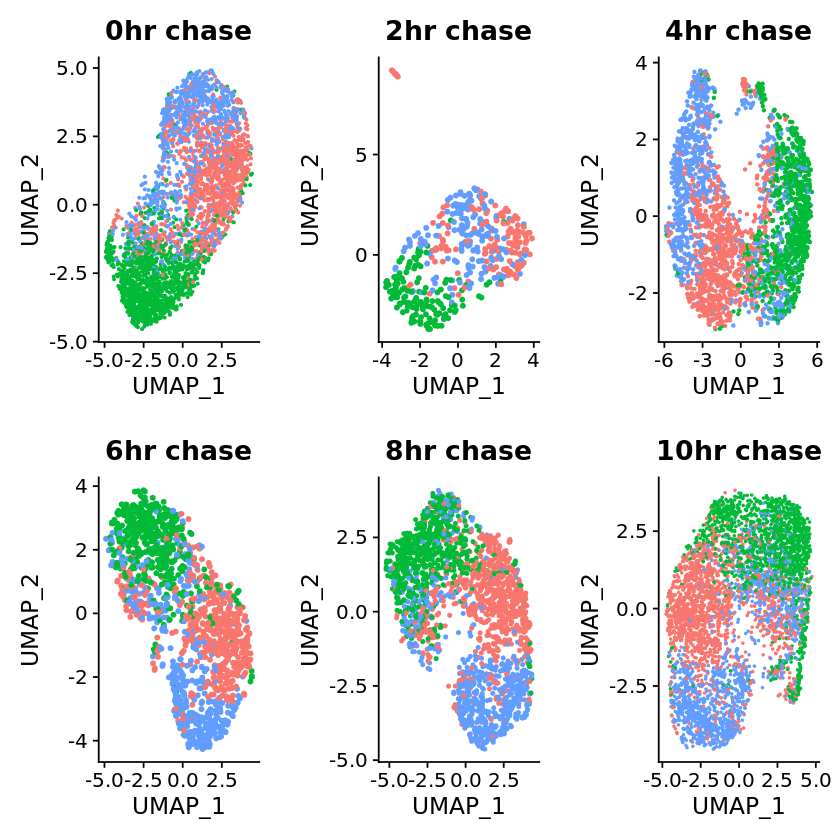

In [21]:
CombinePlots(UMAP_562_cell_cycle_timepoint, ncol = NULL, legend = "none")


# Assessing the number of correlations per TF

How many significant correlations for total:total? This is only for CHIP TFs


In [52]:
correlations_total_TF_total_target <- read_csv(paste(working_directory,"correlations_JL_011_no_doublets_total_TF_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))

New names:
• `` -> `...1`
Rows: 2856169 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): TF, target
dbl (24): ...1, rho_0hr, p.value0hr, q_value_0hr, rho_2hr, p.value2hr, q_val...
lgl  (6): needs_more_permut_0hr, needs_more_permut_2hr, needs_more_permut_4h...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
correlations_total_TF_total_target <- correlations_total_TF_total_target[,-1]
correlations_total_TF_total_target<-correlations_total_TF_total_target[-c(1),]

significant_correlations <- correlations_total_TF_total_target%>%
  filter(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 & p.value6hr < 0.05 & p.value8hr < 0.05 & p.value10hr < 0.05) %>%
  filter(TF != target) 
TFs_for_chip_with_enough_targets<-unique(significant_correlations$TF)[which(as.numeric(table(significant_correlations$TF)) > 15)]

#How many links per TF?
summary(as.numeric(table(significant_correlations$TF)))
TFs_for_chip_with_enough_targets<-unique(significant_correlations$TF)[which(as.numeric(table(significant_correlations$TF)) > 15)]

length(TFs_for_chip_with_enough_targets)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00   13.00   31.66   40.25  271.00 

[1] 70

How many significant correlations for total:total? This is for all expressed TFs

In [56]:
correlations_total_TF_total_target <- read_csv(paste(working_directory,"correlations_JL_011_no_doublets_total_ALL_EXPRESSED_TFs_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))
correlations_total_TF_total_target <- correlations_total_TF_total_target[,-1]
correlations_total_TF_total_target<-correlations_total_TF_total_target[-c(1),]

significant_correlations <- correlations_total_TF_total_target%>%
  filter(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 & p.value6hr < 0.05 & p.value8hr < 0.05 & p.value10hr < 0.05) %>%
  filter(TF != target) 

significant_correlations %>%
  filter(TF == "GATA1") 

#How many links per TF?
summary(as.numeric(table(significant_correlations$TF)))
expressed_TFs_with_enough_targets<-unique(significant_correlations$TF)[which(as.numeric(table(significant_correlations$TF)) > 1)]
length(expressed_TFs_with_enough_targets<-unique(significant_correlations$TF)[which(as.numeric(table(significant_correlations$TF)) > 1)])

significant_correlations_expressed_TFs_with_enough_targets <-significant_correlations %>%
  filter(TF %in% expressed_TFs_with_enough_targets)
summary(as.numeric(table(significant_correlations_expressed_TFs_with_enough_targets$TF)))

length(TFs_for_chip_with_enough_targets)

New names:
• `` -> `...1`
Rows: 13362788 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): TF, target
dbl (24): ...1, rho_0hr, p.value0hr, q_value_0hr, rho_2hr, p.value2hr, q_val...
lgl  (6): needs_more_permut_0hr, needs_more_permut_2hr, needs_more_permut_4h...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TF    target     rho_0hr     p.value0hr   q_value_0hr needs_more_permut_0hr
1  GATA1 AC079466.1  0.07431661 3.799996e-05 0.020509122 FALSE                
2  GATA1 AC079801.1  0.08163783 9.999990e-06 0.014572271 FALSE                
3  GATA1 ALAS2       0.03594600 4.776995e-02 0.390638267 FALSE                
4  GATA1 ANKRD11    -0.04027633 2.660397e-02 0.311088778 FALSE                
5  GATA1 ATP5J       0.07197668 8.199992e-05 0.032047830 FALSE                
6  GATA1 ATP5O       0.06377237 4.699995e-04 0.064963106 FALSE                
7  GATA1 BLVRB       0.04336278 1.682798e-02 0.257127474 FALSE                
8  GATA1 CCND3       0.06522519 3.359997e-04 0.053956171 FALSE                
9  GATA1 CLIC2       0.03709633 4.096596e-02 0.366263028 FALSE                
10 GATA1 COX7B       0.04397655 1.531798e-02 0.250404309 FALSE                
11 GATA1 FAXDC2      0.04123568 2.301798e-02 0.294351480 FALSE                
12 GATA1 FSCN1       0.05678033 1.757998e-03 0.104249083 FALSE                
13 GATA1 FTH1P10     0.05272619 3.681996e-03 0.138600606 FALSE                
14 GATA1 HBG1        0.08149954 1.199999e-05 0.014572271 FALSE                
15 GATA1 HBG2        0.07878905 1.599998e-05 0.014572271 FALSE                
16 GATA1 HBZ         0.03956312 2.921997e-02 0.322472394 FALSE                
17 GATA1 HSPE1       0.06022588 9.339991e-04 0.085258661 FALSE                
18 GATA1 LMO2        0.05329451 3.333997e-03 0.133998292 FALSE                
19 GATA1 MAGEC2      0.03599614 4.746995e-02 0.389853099 FALSE                
20 GATA1 MT-RNR2    -0.12523258 1.999998e-06 0.007555992  TRUE                
21 GATA1 MYL4        0.05679154 1.753998e-03 0.104249083 FALSE                
22 GATA1 NDUFS6      0.08561856 5.999994e-06 0.014572271 FALSE                
23 GATA1 NME1        0.04813028 7.907992e-03 0.197335952 FALSE                
24 GATA1 NPM1        0.09330289 1.999998e-06 0.007555992  TRUE                
25 GATA1 PGK1        0.04467655 1.370199e-02 0.239563263 FALSE                
26 GATA1 PPOX        0.03966045 2.885797e-02 0.320662985 FALSE                
27 GATA1 RBM38       0.04961718 6.135994e-03 0.173863386 FALSE                
28 GATA1 RPL38       0.04782206 8.337992e-03 0.202361451 FALSE                
29 GATA1 SDF2L1      0.05376651 3.063997e-03 0.129924179 FALSE                
30 GATA1 SLC25A37    0.05245927 3.863996e-03 0.140941903 FALSE                
⋮  ⋮     ⋮          ⋮           ⋮            ⋮           ⋮                    
43 GATA1 BLVRB       0.04336278 1.682798e-02 0.257127474 FALSE                
44 GATA1 CCND3       0.06522519 3.359997e-04 0.053956171 FALSE                
45 GATA1 CLIC2       0.03709633 4.096596e-02 0.366263028 FALSE                
46 GATA1 COX7B       0.04397655 1.531798e-02 0.250404309 FALSE                
47 GATA1 FAXDC2      0.04123568 2.301798e-02 0.294351480 FALSE                
48 GATA1 FSCN1       0.05678033 1.757998e-03 0.104249083 FALSE                
49 GATA1 FTH1P10     0.05272619 3.681996e-03 0.138600606 FALSE                
50 GATA1 HBG1        0.08149954 1.199999e-05 0.014572271 FALSE                
51 GATA1 HBG2        0.07878905 1.599998e-05 0.014572271 FALSE                
52 GATA1 HBZ         0.03956312 2.921997e-02 0.322472394 FALSE                
53 GATA1 HSPE1       0.06022588 9.339991e-04 0.085258661 FALSE                
54 GATA1 LMO2        0.05329451 3.333997e-03 0.133998292 FALSE                
55 GATA1 MAGEC2      0.03599614 4.746995e-02 0.389853099 FALSE                
56 GATA1 MT-RNR2    -0.12523258 1.999998e-06 0.007555992  TRUE                
57 GATA1 MYL4        0.05679154 1.753998e-03 0.104249083 FALSE                
58 GATA1 NDUFS6      0.08561856 5.999994e-06 0.014572271 FALSE                
59 GATA1 NME1        0.04813028 7.907992e-03 0.197335952 FALSE                
60 GATA1 NPM1        0.09330289 1.999998e-06 0.007555992  TRUE                
61 GATA1 PGK1        0.04467655 1.370199e-02 0.239563

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00   15.00   45.83   52.00  542.00 

[1] 342

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    5.00   18.00   50.15   58.00  542.00 

[1] 70

# Comparison of correlated genes with an orthogonal CRISPRi dataset (panels 4C, S4G and S4H)

Using the published K562 CRISPRi dataset from the Weissman lab to validate targets using mixscape (https://www.nature.com/articles/s41588-021-00778-2)

In [3]:
rawdata <- Read10X(data.dir = working_directory)
seurat_object = CreateSeuratObject(counts = rawdata)
# Downsample
#seurat_object <- subset(seurat_object, cells=sample(Cells(seurat_object), length(Cells(seurat_object))/2))


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
# Normalize data, find variable features and scale data.
DefaultAssay(object = seurat_object) <- 'RNA'
seurat_object <- NormalizeData(object = seurat_object) %>% FindVariableFeatures() %>% ScaleData()
# Run Principle Component Analysis (PCA) to reduce the dimensionality of the data.
seurat_object <- RunPCA(object = seurat_object)
# Run Uniform Manifold Approximation and Projection (UMAP) to visualize clustering in 2-D.
seurat_object <- RunUMAP(object = seurat_object, dims = 1:40)



Centering and scaling data matrix

PC_ 1 
Positive:  RANBP1, NME1, PTMA, HMGB1, RAN, HSPE1, ATP5G3, ATP5G1, CYCS, SLIRP 
	   GAL, TOMM40, TUBA1B, SRM, UQCRQ, PA2G4, MRPL12, POLR3K, CKB, PDCD5 
	   LDHA, DTYMK, FABP5, ENO1, NOP16, TXN, CKS1B, NCL, CKS2, ATPIF1 
Negative:  SH3BGRL3, SAT1, DDIT3, HERPUD1, SMIM14, EEF1A1, DDIT4, TSC22D3, C10orf54, ZFAS1 
	   S100A13, LGALS1, TES, YPEL5, TRPM4, CCPG1, LST1, CORO1A, DNAJB9, C6orf48 
	   YPEL3, GDF15, S100A11, TYROBP, FCER1G, NUPR1, FILIP1L, CSF3R, SAT2, MEI1 
PC_ 2 
Positive:  RPS28, RPL34, RPL12, RPL3, RPL10A, EEF1A1, RPS27, APOC1, RPS24, RPS29 
	   EEF2, SLC25A37, HNRNPA1, HBZ, RPS6, ALAS2, RPL26, SLC25A6, RP11-717F1.1, HIST3H2A 
	   HBG2, HBA1, MYL4, COL18A1, EIF3L, RPS5, KLF1, MT-ND3, FEZ1, AC016629.3 
Negative:  CLIC1, SPCS2, EIF1, UBE2L3, EXOSC8, UBB, CD63, PSMA4, DDIT3, CALM2 
	   S100A11, ACTB, UBC, UFD1L, CACYBP, PSMD7, EIF5, RBM8A, KIF5B, NUCKS1 
	   NUDC, PDIA6, PSME2, SLC3A2, NOL7, CCT5, DNAJB11, CCNB1, DYNLL1, PSMB1 
PC_ 3 
Posi

In [9]:
# Check Perturbation Status - use CBC-GBC dictionary
CBC_GBC_dict <- read.csv(file = paste(working_directory,"cell_identities_no_empty_cell.csv.gz",sep=""), 
                         header = TRUE)
#CBC_GBC_dict <- CBC_GBC_dict %>% select(cell_barcode ,guide_identity)
CBC_GBC_dict$guide_identity <- str_replace_all(CBC_GBC_dict$guide_identity, "neg", "NT")
CBC_GBC_dict$guide_identity <- sapply(strsplit(CBC_GBC_dict$guide_identity,"_"), `[`, 1)


In [10]:
vector_of_GBC <- vector()
vector_of_GBC <- CBC_GBC_dict$guide_identity
names(vector_of_GBC) <- CBC_GBC_dict$cell_barcode
table(vector_of_GBC)
intersect_GBC_seurat <- vector_of_GBC[intersect(names(seurat_object$orig.ident),names(vector_of_GBC))]
seurat_object <- seurat_object[,names(intersect_GBC_seurat) ]
seurat_object@meta.data$gene <- intersect_GBC_seurat

intersect_GBC_seurat[grepl("NT",intersect_GBC_seurat, fixed=TRUE)] <- "NT"
intersect_GBC_seurat[!grepl("NT",intersect_GBC_seurat, fixed=TRUE)] <- "Perturbed"
seurat_object$crispr <- factor(intersect_GBC_seurat)
seurat_object@meta.data$gem <- sapply(strsplit(rownames(seurat_object@meta.data), "-"), "[[", 2)

# Calculate perturbation signature (PRTB).
seurat_object<- CalcPerturbSig(
  object = seurat_object, 
  assay = "RNA", 
  slot = "data", 
  gd.class ="gene", 
  nt.cell.class = "NT", 
  reduction = "pca", 
  ndims = 20, 
  num.neighbors = 20,
  new.assay.name = "PRTB")


# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = seurat_object) <- 'PRTB'


# Use variable features from RNA assay.
VariableFeatures(object = seurat_object) <- VariableFeatures(object = seurat_object[["RNA"]])
seurat_object <- ScaleData(object = seurat_object, do.scale = F, do.center = T)

# Run PCA to reduce the dimensionality of the data.
seurat_object <- RunPCA(object = seurat_object, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
seurat_object <- RunUMAP(
  object = seurat_object, 
  dims = 1:20, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap_', 
  reduction.name = 'prtbumap')

# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.


# assign NT data
#tmp <- sub("Control", "NT", seurat_object$gene)
seurat_object$NT <- as.factor(seurat_object$gene)

vector_of_GBC
  ALDOA   ATP5E     BCR     CAD   CDC23   COX11    DBR1     DUT  EIF2S1   GATA1 
    627     834     874     878     835     934    1112    1246     616     579 
  GINS1  GNB2L1   HSPA5   HSPA9   HSPE1    MTOR      NT  POLR1D  POLR2H     RAN 
    906    1008     748     542     979     967    2446    1379     496     877 
   RPL9   RPS14   RPS15   RPS18 SEC61A1    TUBB 
    616     962     700     631     830     675 

Processing rep1

Centering data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  HBG2, HBZ, HIST1H1C, TUBA1B, HIST1H4C, HSPE1, NME1, GAL, PTMA, RANBP1 
	   HMGB1, HBG1, KIAA0101, CKS1B, SRM, UBE2S, PHF19, APOC1, HBA1, HIST1H2BJ 
	   CKB, PTTG1, HSP90AA1, HMGB2, CKS2, RAN, ODC1, FABP5, HSPA8, TUBB 
Negative:  DDIT3, S100A11, PDIA4, SH3BGRL3, TRAPPC6A, DNAJB11, HERPUD1, MANF, PPIB, FCER1G 
	   SLC3A2, NANS, NUCB2, BTG1, ZFAS1, PPP1R18, S100A13, PDIA3, DNAJC3, RABAC1 
	   UBC, SSR4, TRIB3, DDIT4, P4HB, LGALS1, HSP90B1, CD63, C6orf48, UBE2L6 
prtbpca_ 2 
Positive:  HBG2, HBZ, HBG1, BLVRB, CHI3L2, GYPB, MYL4, ALAS2, SLC25A37, APOE 
	   HBA1, APOC1, GSTP1, HBD, GYPA, SQLE, HIST3H2A, KLF1, RP11-717F1.1, ANXA2 
	   CRYM, COL18A1, NEAT1, MS4A3, FAM210B, 

ERROR: Error: Please install the mixtools package to use RunMixscape
This can be accomplished with the following command: 
----------------------------------------
install.packages('mixtools')
----------------------------------------


In [12]:
# Run mixscape.
Idents(seurat_object) <- "NT"
seurat_object <- RunMixscape(
  object = seurat_object, 
  assay = "PRTB", 
  slot = "scale.data", 
  labels = "gene", 
  nt.class.name = "NT", 
  min.de.genes = 1, 
  iter.num = 40, 
  de.assay = "RNA",
  logfc.threshold = 0.1,
  verbose = T)

Processing RAN

Finding new perturbation gene set

Processing POLR2H

Finding new perturbation gene set

Processing TUBB

Finding new perturbation gene set

Processing CDC23

Finding new perturbation gene set

Processing POLR1D

Finding new perturbation gene set

Processing DUT

Finding new perturbation gene set

Processing HSPA5

Finding new perturbation gene set

Processing MTOR

Finding new perturbation gene set

Processing GATA1

Finding new perturbation gene set

Processing GINS1

Finding new perturbation gene set

Processing HSPE1

Finding new perturbation gene set

Processing RPS14

Finding new perturbation gene set

Processing EIF2S1

Finding new perturbation gene set

Processing DBR1

Finding new perturbation gene set

Processing CAD

Finding new perturbation gene set

Processing SEC61A1

Finding new perturbation gene set

Processing RPL9

Finding new perturbation gene set

Processing HSPA9

Finding new perturbation gene set

Processing RPS18

Finding new perturbation gene set

number of iterations= 84 
number of iterations= 59 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of iterations= 71 
number of iterations= 70 
number of it

  POLR2H



number of iterations= 16 
number of iterations= 15 
number of iterations= 15 


  TUBB



number of iterations= 27 
number of iterations= 26 
number of iterations= 26 
number of iterations= 26 
number of iterations= 26 
number of iterations= 26 
number of iterations= 26 


  CDC23



number of iterations= 23 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 
number of iterations= 20 


  POLR1D



number of iterations= 39 
number of iterations= 24 
number of iterations= 28 
number of iterations= 29 


  DUT



number of iterations= 38 
number of iterations= 36 
number of iterations= 35 
number of iterations= 35 


  HSPA5



number of iterations= 10 
number of iterations= 10 
number of iterations= 10 


  MTOR



number of iterations= 50 
number of iterations= 46 
number of iterations= 45 


  GATA1



number of iterations= 12 
number of iterations= 11 


  GINS1



number of iterations= 33 
number of iterations= 30 
number of iterations= 30 
number of iterations= 30 
number of iterations= 30 
number of iterations= 30 


  HSPE1



number of iterations= 31 
number of iterations= 32 
number of iterations= 32 
number of iterations= 32 


  RPS14



number of iterations= 26 
number of iterations= 25 
number of iterations= 25 


  EIF2S1



number of iterations= 14 
number of iterations= 14 
number of iterations= 14 


  DBR1



number of iterations= 37 
number of iterations= 31 
number of iterations= 32 
number of iterations= 32 
number of iterations= 32 


  CAD



number of iterations= 19 
number of iterations= 17 
number of iterations= 17 


  SEC61A1



number of iterations= 30 
number of iterations= 27 
number of iterations= 27 
number of iterations= 27 


  RPL9



number of iterations= 16 
number of iterations= 15 
number of iterations= 15 


  HSPA9



number of iterations= 22 
number of iterations= 22 
number of iterations= 22 


  RPS18



number of iterations= 30 
number of iterations= 29 
number of iterations= 29 


  ALDOA



number of iterations= 60 
number of iterations= 57 
number of iterations= 57 
number of iterations= 57 


  RPS15



number of iterations= 28 
number of iterations= 26 
number of iterations= 26 


  ATP5E



number of iterations= 44 
number of iterations= 43 
number of iterations= 42 
number of iterations= 42 
number of iterations= 42 
number of iterations= 42 
number of iterations= 42 


  COX11



number of iterations= 183 
number of iterations= 136 
number of iterations= 111 
number of iterations= 77 
number of iterations= 93 
number of iterations= 85 


  BCR



number of iterations= 14 
number of iterations= 14 
number of iterations= 14 


  GNB2L1



number of iterations= 26 
number of iterations= 20 
number of iterations= 20 


In [13]:
saveRDS(seurat_object, paste(working_directory,"weissman_lab_seurat_obj_post_mixscape.RDS",sep=""))


In [2]:
seurat_object = readRDS(paste(working_directory,"weissman_lab_seurat_obj_post_mixscape.RDS",sep=""))


In [3]:
#source("Mixscape_revised_KO.R")
######### Loop through all possible guides #################
#for (perturbation_gene in names(table(seurat_object$gene))[18:26]){
perturbation_gene = "GATA1"
#seurat_object@meta.data$mixscape_class.global <- str_replace_all(seurat_object@meta.data$mixscape_class.global, "KO", "KO")
#seurat_object@meta.data$mixscape_class <- str_replace_all(seurat_object@meta.data$mixscape_class, "KO", "KO")

# Run DE analysis and visualize results on a heatmap ordering cells by their posterior 
# probability values.

# source the revised mixscape heatmap function to extract the DE genes
source(paste(working_directory,"MixscapeHeatmap_DEG.R",sep=""))

# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(seurat_object) <- "mixscape_class.global"
sub <- subset(seurat_object, idents = c("KO", "NT"))

# Run LDA.
sub <- MixscapeLDA(
  object = sub, 
  assay = "RNA", 
  pc.assay = "PRTB", 
  labels = "gene", 
  nt.label = "NT", 
  npcs = 10, 
  logfc.threshold = 0.1, 
  verbose = T)

# Use LDA results to run UMAP and visualize cells on 2-D. 
# Here, we note that the number of the dimensions to be used is equal to the number of 
# labels minus one (to account for NT cells).
sub <- RunUMAP(
  object = sub,
  dims = 1:20,
  reduction = 'lda',
  reduction.key = 'ldaumap',
  reduction.name = 'ldaumap')

# Visualize UMAP clustering results.
Idents(sub) <- "mixscape_class"
sub$mixscape_class<-gsub("KO", "KD", sub$mixscape_class)
sub$mixscape_class <- as.factor(sub$mixscape_class)


TUBB

Finding new perturbation gene set

CDC23

Finding new perturbation gene set

DUT

Finding new perturbation gene set

HSPA5

Finding new perturbation gene set

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
MTOR

Finding new perturbation gene set

GINS1

Finding new perturbation gene set

HSPE1

Finding new perturbation gene set

EIF2S1

Finding new perturbation gene set

GATA1

Finding new perturbation gene set

DBR1

Finding new perturbation gene set

CAD

Finding new perturbation gene set

SEC61A1

Finding new perturbation gene set

RPL9

Finding new perturbation gene set

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
HSPA9

Finding new perturbation gene set

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
RPS18

Finding new perturbation gene set

ALDOA

Finding new perturbation gene set

RPS15

Finding new pertur

LDA_ 1 
Positive:  HSPA5.HSPA5_PC_1, RPL9.RPL9_PC_1, RPS15.RPS15_PC_1, HSPE1.HSPE1_PC_4, POLR2H.POLR2H_PC_2, RPS15.RPS15_PC_2, GATA1.GATA1_PC_1, RPS14.RPS14_PC_7, HSPE1.HSPE1_PC_2, POLR1D.POLR1D_PC_1 
	   SEC61A1.SEC61A1_PC_1, RPS14.RPS14_PC_2, GNB2L1.GNB2L1_PC_1, CAD.CAD_PC_1, DUT.DUT_PC_1, RPS15.RPS15_PC_4, RPL9.RPL9_PC_3, HSPA9.HSPA9_PC_5, GATA1.GATA1_PC_6, GATA1.GATA1_PC_7 
	   SEC61A1.SEC61A1_PC_3, RPL9.RPL9_PC_6, MTOR.MTOR_PC_1, EIF2S1.EIF2S1_PC_7, GINS1.GINS1_PC_2, HSPE1.HSPE1_PC_6, RPS14.RPS14_PC_1, DUT.DUT_PC_3, HSPA9.HSPA9_PC_3, CAD.CAD_PC_2 
Negative:  HSPA5.HSPA5_PC_3, RPS18.RPS18_PC_1, HSPA9.HSPA9_PC_1, EIF2S1.EIF2S1_PC_3, HSPA9.HSPA9_PC_7, POLR2H.POLR2H_PC_1, HSPA5.HSPA5_PC_10, RPS18.RPS18_PC_2, RPS18.RPS18_PC_3, GATA1.GATA1_PC_2 
	   MTOR.MTOR_PC_4, BCR.BCR_PC_1, SEC61A1.SEC61A1_PC_2, BCR.BCR_PC_4, EIF2S1.EIF2S1_PC_5, HSPA5.HSPA5_PC_9, HSPE1.HSPE1_PC_10, EIF2S1.EIF2S1_PC_1, RPL9.RPL9_PC_5, TUBB.TUBB_PC_2 
	   DUT.DUT_PC_7, ATP5E.ATP5E_PC_2, POLR2H.POLR2H_PC_3, DUT.DUT_PC

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:12:06 UMAP embedding parameters a = 0.9922 b = 1.112

18:12:06 Read 15369 rows and found 20 numeric columns

18:12:06 Using Annoy for neighbor search, n_neighbors = 30

18:12:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:12:08 Writing NN index file to temp file /tmp/RtmphBgE74/file8325dab5a3

18:12:08 Searching Annoy index using 1 thread, search_k = 3000

18:12:16 Annoy recall = 100%

18:12:17 Commencing smooth kNN distance calibration using 1 thread

18:12:18 Initializing from

ERROR: Error in hue_pal(): could not find function "hue_pal"


In [12]:
# Set colors for each perturbation.
col = setNames(object = hue_pal()(26),nm = levels(sub$mixscape_class)[c(10,17,1:9,11:16,18:26)])
col[3:26] = setNames(object = hue_pal()(26)[2:25],nm = levels(sub$mixscape_class)[c(3:26)])
names(col) <- c(names(col)[1], "NT", names(col)[3:26])
names(col) <- gsub("KO", "KD", names(col))
col[2] <- "grey39"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



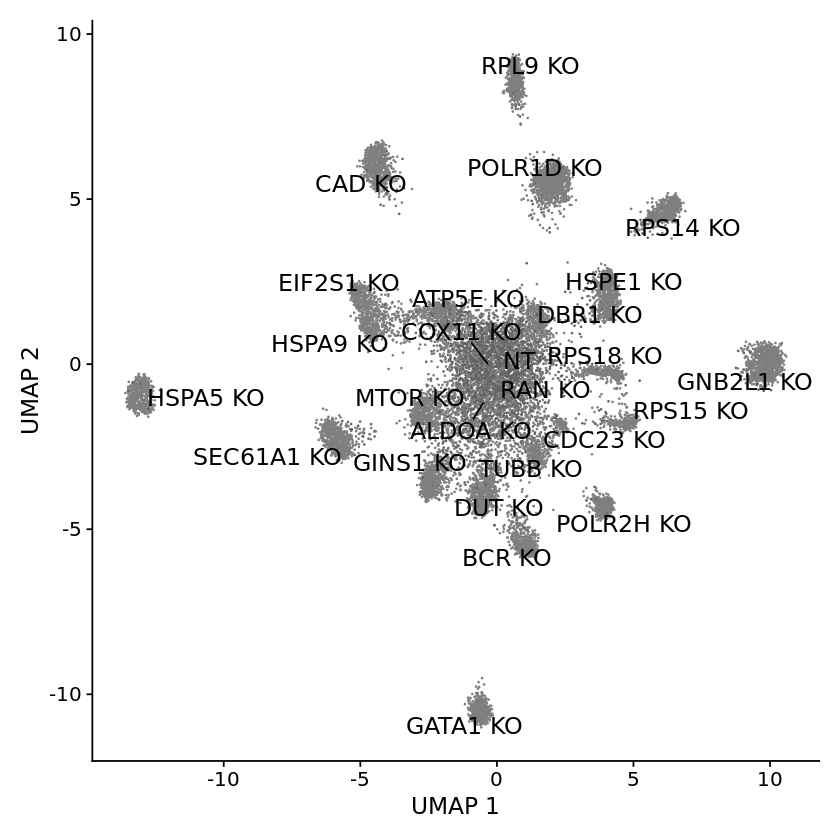

In [13]:
p <- DimPlot(object = sub,
             reduction = "ldaumap",
             repel = T,
             label.size = 5,
             label = T,
             cols = col) + NoLegend()
p2 <- p+
  scale_color_manual(values=col, drop=FALSE) +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme 
p2

The group.by parameter is being deprecated. Please use mixscape.class instead. Setting mixscape.class = mixscape_class and continuing.

Centering and scaling data matrix

The group.by parameter is being deprecated. Please use mixscape.class instead. Setting mixscape.class = mixscape_class and continuing.

Centering and scaling data matrix



[[1]]
                            p_val   avg_log2FC pct.1 pct.2     p_val_adj
ITGB2               8.945616e-278 1.295046e+00 0.676 0.044 3.014136e-273
LST1                8.245929e-257 2.716326e+00 0.904 0.201 2.778383e-252
LTB                 1.433099e-254 3.636299e+00 0.878 0.177 4.828683e-250
C10orf54            6.598383e-244 8.628078e-01 0.536 0.020 2.223259e-239
TYROBP              4.448102e-238 2.612986e+00 0.858 0.184 1.498744e-233
CORO1A              7.149521e-231 1.585708e+00 0.790 0.138 2.408960e-226
JCHAIN              4.158285e-225 1.832150e+00 0.510 0.022 1.401093e-220
ANKRD55             3.099466e-218 5.995764e-01 0.409 0.004 1.044334e-213
EVI2B               2.266582e-213 9.345713e-01 0.567 0.044 7.637020e-209
CD48                2.935297e-207 8.903569e-01 0.433 0.011 9.890188e-203
LGALS1              4.567698e-207 2.827656e+00 0.995 0.878 1.539040e-202
GSN                 2.071986e-203 9.259609e-01 0.648 0.083 6.981349e-199
TMSB4X              3.056170e-197 2.108085e+00 1.000 1.000 1.029746e-192
S100A4              6.008383e-188 2.325914e+00 0.951 0.533 2.024464e-183
CYBA                4.556316e-181 1.556433e+00 1.000 0.992 1.535205e-176
CSF3R               2.812599e-175 1.224336e+00 0.645 0.110 9.476772e-171
S100A13             2.209508e-172 1.845302e+00 0.974 0.762 7.444715e-168
ACTG1               1.188286e-167 1.475444e+00 1.000 1.000 4.003811e-163
PLD3                2.437627e-164 1.600025e+00 0.974 0.814 8.213339e-160
AIF1                2.839467e-163 2.103269e+00 0.863 0.384 9.567299e-159
CYTH4               3.038529e-160 4.495302e-01 0.319 0.005 1.023802e-155
SMIM3               1.483366e-159 6.041948e-01 0.381 0.018 4.998055e-155
SH3BGRL3            2.317952e-159 1.699370e+00 0.979 0.886 7.810106e-155
CFL1                2.843206e-159 8.771897e-01 1.000 1.000 9.579897e-155
MYO1F               1.057623e-158 9.921685e-01 0.624 0.117 3.563555e-154
ITGB2-AS1           9.661899e-158 4.508286e-01 0.342 0.010 3.255480e-153
B2M                 1.493164e-156 1.004646e+00 1.000 0.998 5.031066e-152
PYCARD              1.263330e-154 1.332537e+00 0.982 0.958 4.256663e-150
CD180               4.227034e-154 4.492962e-01 0.303 0.004 1.424257e-149
CTSC                5.054172e-154 2.444291e+00 0.982 0.941 1.702953e-149
SOCS1               1.167512e-153 1.395008e+00 0.826 0.339 3.933813e-149
BTG1                1.102611e-149 1.615468e+00 0.995 0.984 3.715139e-145
MALAT1              3.837338e-149 1.275871e+00 1.000 1.000 1.292953e-144
ACTB                4.980654e-149 1.005313e+00 1.000 1.000 1.678182e-144
RASSF2              2.939016e-146 6.736326e-01 0.510 0.069 9.902720e-142
ARPC1B              1.095406e-145 1.079029e+00 0.997 0.997 3.690861e-141
S100A11             2.757804e-145 1.113699e+00 0.995 0.991 9.292146e-141
DBI                 2.203830e-142 1.483678e+00 1.000 0.996 7.425584e-138
CCNI                3.251216e-141 9.664475e-01 1.000 0.998 1.095465e-136
FCER1G              4.623056e-140 1.813161e+00 0.889 0.595 1.557692e-135
CD52                1.822184e-138 1.255327e+00 0.578 0.111 6.139667e-134
PRAM1               5.618517e-138 3.937071e-01 0.267 0.003 1.893103e-133
MPC2                5.796400e-134 1.069754e+00 0.977 0.940 1.953039e-129
IDH2                1.210322e-133 1.365423e+00 0.951 0.912 4.078060e-129
MT-CO1              7.539371e-133 5.281871e-01 1.000 1.000 2.540316e-128
PIM1                2.671755e-131 1.521448e+00 0.925 0.758 9.002211e-127
BHLHE40             6.129139e-131 1.119482e+00 0.925 0.725 2.065152e-126
GLIPR1              7.686088e-131 6.646026e-01 0.272 0.006 2.589750e-126
ATF7IP2             1.073446e-126 1.597304e+00 0.992 0.958 3.616869e-122
TPT1                1.725464e-125 5.359351e-01 1.000 1.000 5.813777e-121
PDE4DIP             1.783026e-125 1.157213e+00 0.969 0.935 6.007727e-121
OLFML3              1.232285e-124 4.814503e-01 0.241 0.002 4.152060e-120
MYL6                4.272423e-124 7.120998e-01 1.000 1.000 1.439550e-119
FILIP1L             6.156195e-123 9.624140e-01 0.446

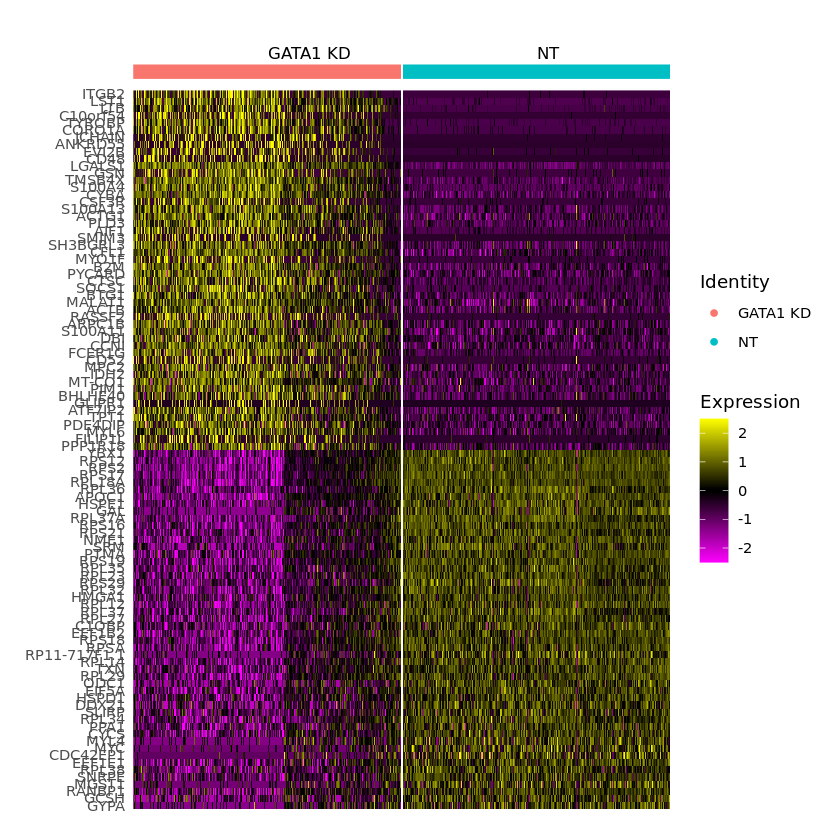

In [18]:
Idents(object = sub) <- "gene"

DEG_list <- MixscapeHeatmap_DEG(object = sub, 
                                ident.1 = perturbation_gene, 
                                ident.2 = "NT", 
                                balanced = T, 
                                assay = "RNA", 
                                max.genes = 100000, angle = 0, 
                                group.by = "mixscape_class", 
                                max.cells.group = 300, 
                                logfc.threshold = 0,
                                pval.cutoff = 1,
                                size=3.5)

DEG_heatmap <- MixscapeHeatmap(object = sub, 
                                ident.1 = perturbation_gene, 
                                ident.2 = "NT", 
                                balanced = T, 
                                assay = "RNA", 
                                max.genes = 100000, angle = 0, 
                                group.by = "mixscape_class", 
                                max.cells.group = 300, 
                                logfc.threshold = 0,
                                pval.cutoff = 1,
                                size=3.5)
MixscapeHeatmap(object = sub, 
                                ident.1 = perturbation_gene, 
                                ident.2 = "NT", 
                                balanced = T, 
                                assay = "RNA", 
                                max.genes = 50, angle = 0, 
                                group.by = "mixscape_class", 
                                max.cells.group = 300, 
                                logfc.threshold = 0.5,
                                pval.cutoff = 0.0001,
                                size=3.5)


DEG_list


DEG_all1 <- DEG_list[[1]]
DEG_all2 <- DEG_list[[2]]


In [19]:
saveRDS(sub, paste(working_directory,"weissman_lab_seurat_obj_post_mixscape_post_LDA.RDS",sep=""))

write.csv(DEG_all2,paste(working_directory,perturbation_gene, '_DEG_decrease.csv', sep=""))
write.csv(DEG_all1,paste(working_directory,perturbation_gene, '_DEG_increase.csv', sep=""))

In [ ]:
#DEG_all2<-read.csv(paste(working_directory,"GATA1_DEG_decrease.csv", sep=""),row.names = 1)

#DEG_all1<-read.csv(paste(working_directory,"GATA1_DEG_increase.csv", sep=""), row.names = 1)


In [22]:
df <- rbind(DEG_all1, DEG_all2)
## Sort by ordered padj
df_ordered <- df[order(df$p_val_adj), ] 
head(df_ordered %>%
  filter(avg_log2FC <0))

# remove the TFs from Perturb using the TF list from the Weinrauch paper
tf_list <- read.csv(paste(working_directory,"curated_human_list_from_weinrauch.csv",sep=""), header= F)
tf_list <- tf_list$V1

df_ordered<-df_ordered[which(row.names(df_ordered) %notin% tf_list),]

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
YBX1   4.055896e-184 -0.8543120 1     1     1.366594e-179
RPS12  1.082958e-182 -0.7354450 1     1     3.648920e-178
RPS2   5.902699e-181 -0.7308471 1     1     1.988855e-176
RPS17  4.397999e-175 -0.6868350 1     1     1.481862e-170
RPL18A 3.649762e-174 -0.7516813 1     1     1.229751e-169
RPL36  1.149812e-170 -0.6369648 1     1     3.874177e-166

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


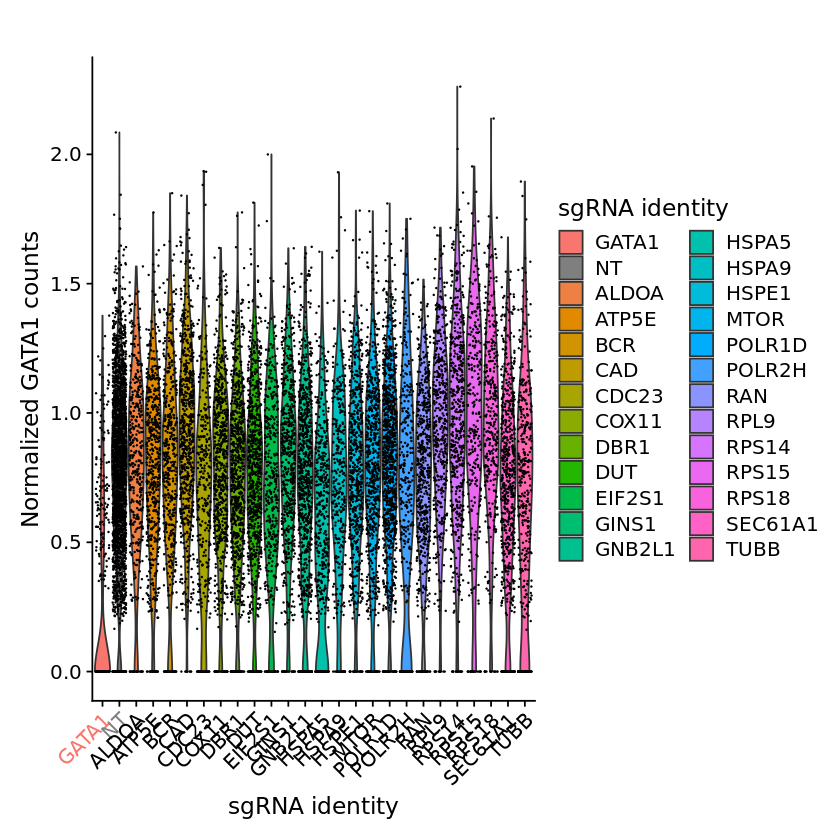

In [23]:
Idents(sub) <- "gene"

levels(x = sub) <- levels(Idents(sub))[c(10,1,2:9,11:26)]
levels(x = sub)[3:26] <-sort(levels(Idents(sub))[3:26])
VlnPlot(sub, "GATA1", slot= "data", assay="RNA", cols = c(hue_pal()(26)[1],"grey50", hue_pal()(26)[2:25]))+ ylab("Normalized GATA1 counts") + ggtitle("") + guides(fill=guide_legend(title="sgRNA identity")) + xlab("sgRNA identity") + theme(axis.text.x = element_text(colour = c(hue_pal()(26)[1],"grey50", rep("black",25))))

In [25]:
Idents(sub) <- "mixscape_class"
sub$mixscape_class<-gsub("KO", "KD", sub$mixscape_class)
sub$mixscape_class <- as.factor(sub$mixscape_class)
Idents(sub) <- "gene"

## Figure S4 Panel G

Warning message in `[[.Seurat`(object, group.by, drop = TRUE):
“Cannot find the following bits of meta data: TUBB, CDC23, DUT, HSPA5, MTOR, DUT, GINS1, HSPE1, EIF2S1, GATA1, DBR1, HSPE1, HSPE1, CAD, SEC61A1, HSPA5, CAD, RPL9, DUT, HSPE1, HSPA9, RPS18, EIF2S1, CDC23, GATA1, ALDOA, EIF2S1, SEC61A1, ALDOA, RPS15, RPS14, EIF2S1, POLR1D, RPS18, ATP5E, RPS14, GINS1, DUT, CAD, HSPA5, TUBB, GATA1, DUT, RPS18, DBR1, ATP5E, DBR1, EIF2S1, SEC61A1, BCR, DBR1, COX11, CAD, DUT, GINS1, COX11, CAD, TUBB, GINS1, RPS18, GATA1, DBR1, SEC61A1, DUT, GNB2L1, CDC23, BCR, HSPE1, DUT, DUT, RPS15, HSPA5, CDC23, ATP5E, CAD, SEC61A1, GINS1, CAD, GATA1, RPS14, GATA1, CDC23, POLR2H, SEC61A1, GINS1, COX11, ATP5E, DBR1, CAD, BCR, SEC61A1, HSPE1, GINS1, RPL9, COX11, CAD, HSPE1, RPS15, CAD, RPS14, COX11, DBR1, RPL9, RAN, GATA1, SEC61A1, MTOR, POLR1D, DBR1, MTOR, CAD, DBR1, RPS14, RPS14, HSPA5, MTOR, CDC23, HSPE1, MTOR, CAD, DUT, ATP5E, GINS1, DUT, GINS1, GINS1, RPS14, HSPA5, ATP5E, POLR1D, DBR1, RPS15, POLR1D, GATA1, E

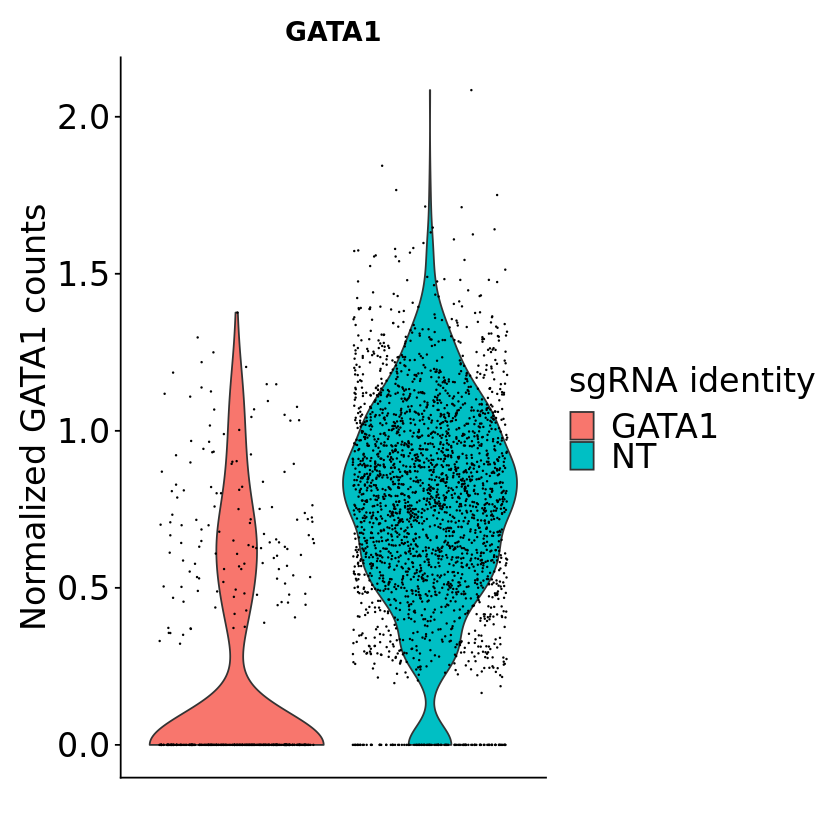

In [27]:
#only GATA1 and NT
VlnPlot(sub[,c(which(sub@meta.data$gene == "NT"),which(sub@meta.data$gene == "GATA1"))], "GATA1", group.by=sub@meta.data$gene, slot= "data", assay="RNA") + ylab("Normalized GATA1 counts") + labs(x="") + theme(
  axis.text.x = element_blank(),
  axis.ticks.x = element_blank()) + guides(fill=guide_legend(title="sgRNA identity")) + theme(axis.text=element_text(size=20),
                                        axis.title=element_text(size=20),legend.title=element_text(size=20),legend.text=element_text(size=20))

## Figure S4 panel H

In [30]:
correlations_total_TF_total_target <- read.csv(paste(working_directory,"correlations_JL_011_no_doublets_total_\"GATA1\"_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))



[1] 36

The group.by parameter is being deprecated. Please use mixscape.class instead. Setting mixscape.class = mixscape_class and continuing.

Centering and scaling data matrix

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



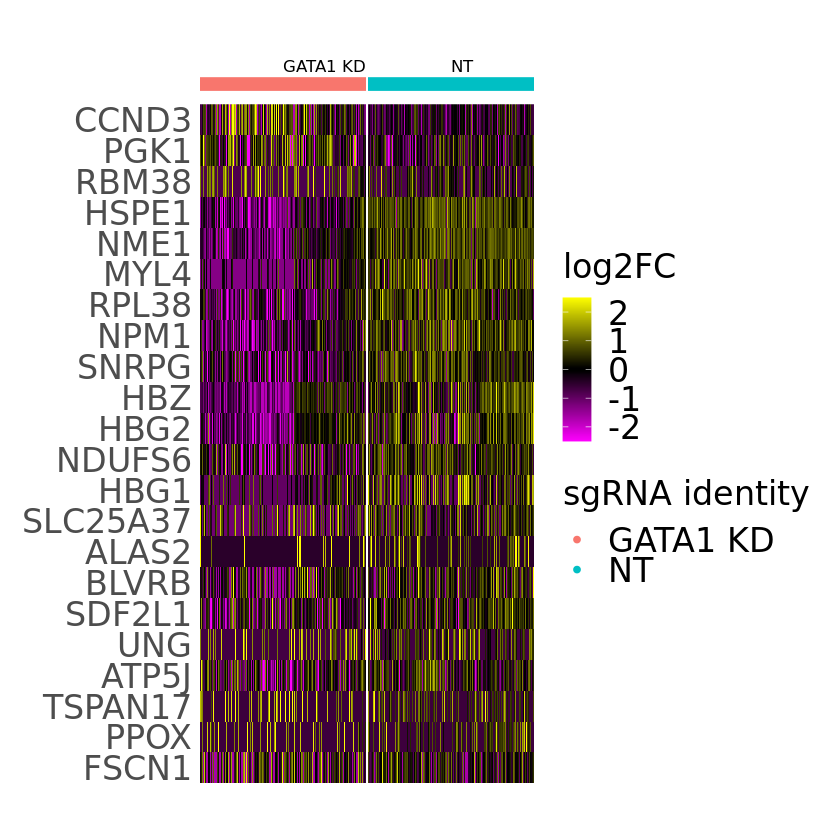

In [31]:
forward<-correlations_total_TF_total_target %>%
    filter(TF == "GATA1") %>%
    filter(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 & p.value6hr < 0.05 & p.value8hr < 0.05 & p.value10hr < 0.05)
dim(forward)[1]
sub_top_genes<-sub[forward$target,]
perturbation_gene="GATA1"

p4<-MixscapeHeatmap(object = sub_top_genes, 
                                ident.1 = perturbation_gene, 
                                ident.2 = "NT", 
                                balanced = T, 
                                assay = "RNA", 
                                max.genes = 50, angle = 0, 
                                group.by = "mixscape_class", 
                                max.cells.group = 300, 
                                logfc.threshold = 0,
                                pval.cutoff = 10^-3,
                                size=3.5) 
p4 + theme(axis.text.y = element_text(size=20), axis.title.x = element_text(size=20),legend.title = element_text(size=20), legend.text = element_text(size=20)) + labs(color='sgRNA identity',fill="log2FC") + scale_color_discrete(guide = FALSE)


## Figure 4 panel C

In [32]:
correlations_total_TF_total_target <- read.csv(paste(working_directory,"correlations_JL_011_no_doublets_total_\"GATA1\"_total_target_considering_cell_cycle_FALSE_10^6_iterations.csv",sep=""))


In [36]:
forward<-correlations_total_TF_total_target %>%
    filter(TF == "GATA1") %>%
    filter(p.value0hr < 0.05 & p.value2hr < 0.05 & p.value4hr < 0.05 & p.value6hr < 0.05 & p.value8hr < 0.05 & p.value10hr < 0.05)
dim(forward)[1]

## Create a column to indicate which genes to label
DIRECT_REG <- df_ordered[which(row.names(df_ordered) %in% forward[which(forward$target %notin% "GATA1"),]$target),] %>%
  filter(p_val_adj < 10^-3)
STATE_REG <- "GATA1"
genes_to_label <- unique(c(row.names(DIRECT_REG), row.names(STATE_REG)))
#"HBG1","HBG2","SLC25A37","TFRC","GYPE","NFE2"
df_ordered$genelabels <- ""
df_ordered$genelabels[which(row.names(df_ordered) %in% genes_to_label)] <- row.names(df_ordered)[which(row.names(df_ordered) %in% genes_to_label)]

[1] 36

Warning message:
“Ignoring unknown parameters: col”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_label_repel).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


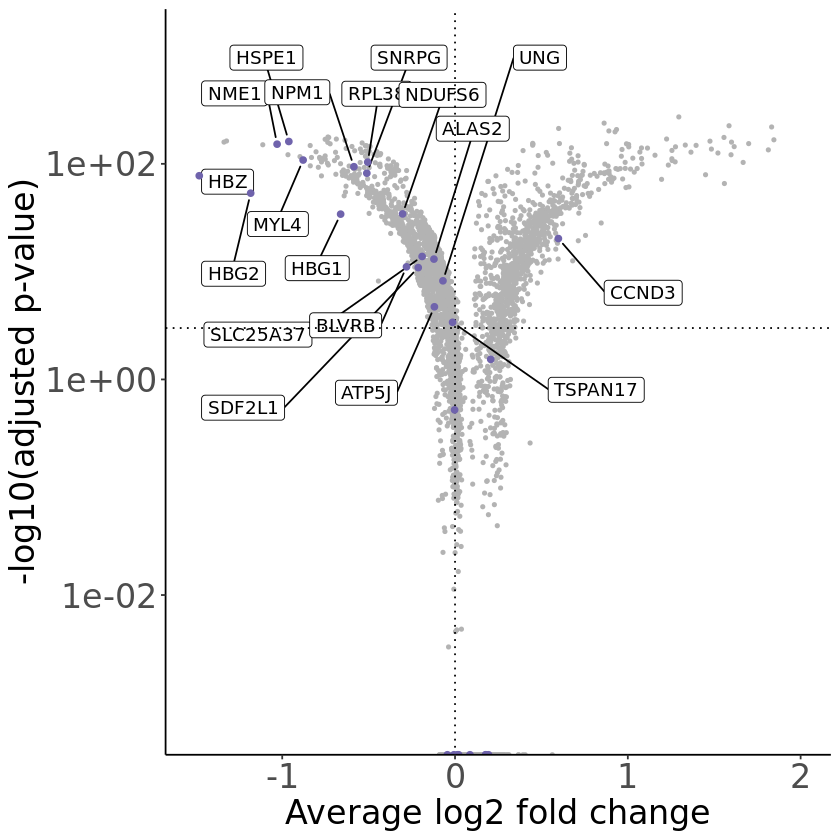

In [39]:
p1 <- ggplot(data=df_ordered, aes(x=avg_log2FC, y=-log10(p_val_adj), label=genelabels)) +
  geom_point(size=0.8, color = "grey70") + 
  theme_minimal() +
  geom_label_repel(box.padding = 1.5, max.overlaps = Inf, point.padding= 0.4) +
  geom_vline(xintercept=c(0), col="black", linetype = 'dotted') +
  geom_hline(yintercept=-log10(10^-3), col="black", linetype = 'dotted', col = 'red') +
  geom_point(data=df_ordered[rownames(df_ordered) %in% forward[which(forward$target %notin% "GATA1"),]$target,], 
             aes(x=avg_log2FC,y=-log10(p_val_adj)), 
             color='#6F63AC') + geom_point(data=df_ordered["GATA1",], 
             aes(x=avg_log2FC,y=-log10(p_val_adj)), 
             color='#E85C5E')
p1 + theme_classic() + scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 1), trans='log10') + xlim(-1.5,2) + theme(axis.text=element_text(size=20),
                                        axis.title=element_text(size=20)) + xlab("Average log2 fold change")+ ylab("-log10(adjusted p-value)")


Enrichment calculation:

In [41]:
# sig vs no sig, 3.83 enrichment
((sum(forward[which(forward$target %notin% "GATA1"),]$target %in% row.names(df_ordered %>%filter(p_val_adj < 10^-3)))) / length(row.names(df_ordered %>%filter(p_val_adj < 10^-3)))) / ((sum(forward[which(forward$target %notin% "GATA1"),]$target %in% row.names(df_ordered %>%filter(p_val_adj > 10^-3)))) / length(row.names(df_ordered %>%filter(p_val_adj > 10^-3))))

[1] 3.828643